In [14]:
!/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade --ignore-installed --force-reinstall https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
!pip install pyarrow
!pip install dask
#Clean up previous tables
!aws s3 rm --recursive s3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables
from move_dl_common_api.athena_util import AthenaUtil
from datetime import datetime
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pickle
from scipy import stats
from sklearn.cluster import KMeans
from datetime import datetime
import pyarrow.parquet as pq
import dask.dataframe as dd
import s3fs
import multiprocessing
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot
s3 = s3fs.S3FileSystem()

  Using cached https://s3-us-west-2.amazonaws.com/move-dl-common-binary-distrubution/python/move_dl_common_api-3.2.131-release.tar.gz
  Using cached https://files.pythonhosted.org/packages/41/dc/68f39fcba61ae642579aca134e2b1139cea4e10341c96772e05c4b0fa727/boto3-1.9.217-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/16/8a/1fc3dba0c4923c2a76e1ff0d52b305c44606da63f718d14d3231e21c51b0/s3transfer-0.2.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/86/79/b4a87f7b177a65dbe5029201fc9d3901e33c2b5f925452ba1cc1fbfff652/botocore-1.12.217-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/83/94/7179c3832a6d45b266ddb2aac329e101367fbdb11f425f13771d27f225bb/jmespath-0.9.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/22/cd/a6aa959dca619918ccb55023b4cb151949c64d4d5d55b3f4ffd7eee0c6e8/docutils-0.15.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e6/60/247f23a7121ae6

In [15]:
# I try to do join on CAP and LEAD for initial data set
# The join condition is based on snap_shot_time
s3_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions'
util = AthenaUtil(s3_staging_folder = s3_path)
# Time to take snap shot
time_stamp = "20190620"

# Drop table if exists
ctas_query_drop_cap_030_timestamp = """DROP TABLE buyer_intent_user_interactions.biui_qa_cap_summary_t030_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_query_drop_cap_030_timestamp)

# Creat Table Again
ctas_query_cap_030_timestamp="""CREATE TABLE buyer_intent_user_interactions.biui_qa_cap_summary_t030_{}
WITH ( format='PARQUET' ) AS
SELECT *
FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_summary_t030
WHERE snapshot_date_mst_yyyymmdd = '{}';""".format(time_stamp,
                                                   time_stamp)

util.execute_query(sql_query = ctas_query_cap_030_timestamp)

2019-08-27 21:40:01.097 INFO athena_util.py.111 - Read config from default schema
2019-08-27 21:40:01.099 INFO athena_util.py.114 - Schema fetched from default config file:
2019-08-27 21:40:01.099 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:40:01.186 INFO athena_util.py.462 - 2019-08-27 21:40:01.186340
2019-08-27 21:40:02.763 INFO athena_util.py.464 - 2019-08-27 21:40:02.763208
2019-08-27 21:40:02.829 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:40:02.890 INFO athena_util.py.462 - 2019-08-27 21:40:02.890921
2019-08-27 21:40:10.687 INFO athena_util.py.464 - 2019-08-27 21:40:10.687336


{'UpdateCount': 184194,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': '95831b55-09a2-47a6-a4b5-e7c472428423',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:40:10 GMT',
   'x-amzn-requestid': '95831b55-09a2-47a6-a4b5-e7c472428423',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [16]:
# Drop table if exists
ctas_query_drop_cap_lead_030_timestamp = """DROP TABLE buyer_intent_user_interactions.biui_qa_cap_lead_summary_t030_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_query_drop_cap_lead_030_timestamp)

ctas_query_cap_lead_030_timestamp="""CREATE TABLE buyer_intent_user_interactions.biui_qa_cap_lead_summary_t030_{}
WITH ( format='PARQUET' ) AS
SELECT *
FROM buyer_intent_user_interactions.biui_qa_consumer_analytical_profile_leads_t030
WHERE snapshot_date_mst_yyyymmdd = '{}';""".format(time_stamp,time_stamp)

util.execute_query(sql_query = ctas_query_cap_lead_030_timestamp)

2019-08-27 21:40:10.757 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:40:10.811 INFO athena_util.py.462 - 2019-08-27 21:40:10.811506
2019-08-27 21:40:12.881 INFO athena_util.py.464 - 2019-08-27 21:40:12.881387
2019-08-27 21:40:12.934 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions
2019-08-27 21:40:12.995 INFO athena_util.py.462 - 2019-08-27 21:40:12.995360
2019-08-27 21:40:18.172 INFO athena_util.py.464 - 2019-08-27 21:40:18.172036


{'UpdateCount': 42518,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': '20e980a9-fc6b-4741-ba43-76c4b1906b6f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:40:17 GMT',
   'x-amzn-requestid': '20e980a9-fc6b-4741-ba43-76c4b1906b6f',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [17]:
s3_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage'
util = AthenaUtil(s3_staging_folder = s3_path)

2019-08-27 21:40:18.232 INFO athena_util.py.111 - Read config from default schema
2019-08-27 21:40:18.233 INFO athena_util.py.114 - Schema fetched from default config file:


In [18]:
param_dict = {
    's3_path': 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables',
     #this time could be changed
    'snap_shot_date':time_stamp,
    'cap_summary_time_filtered':'biui_qa_cap_summary_t030',
    'caplead_summary_time_filtered':'biui_qa_cap_lead_summary_t030'
}

In [19]:
ctas_drop_cap_lead_trans_30 = """DROP TABLE buyer_intent_user_interactions_stage.cap_lead_trans_030_{};""".format(time_stamp)
util.execute_query(sql_query = ctas_drop_cap_lead_trans_30)

ctas_create_cap_lead_trans = """CREATE TABLE buyer_intent_user_interactions_stage.cap_lead_trans_030_{snap_shot_date} WITH (
external_location = '{s3_path}/cap_lead_trans_030_{snap_shot_date}',
format='PARQUET'
) AS
SELECT
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.member_id,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_saved_listings,
-- Search behaviour of the user
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_saved_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_searches,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_min_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_max_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_number_of_bedrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_search_number_of_bathrooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_srp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_srp_dwell_time_seconds,
-- Exploring different items with more detail interactions
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_page_views,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.minimum_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.maximum_ldp_dwell_time_seconds,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_distinct_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_listings_viewed,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_number_of_bath_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_number_of_bed_rooms,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_current_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.median_ldp_listing_original_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.average_ldp_listing_original_price,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.standard_deviation_ldp_listing_original_price,
-- Behavior of the user in submitting leads
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.total_leads_submitted,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_for_rent,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_for_sale,
buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.submitted_leads_not_for_sale,
-- Behaviour for doing transactions
buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}.consumer_score_probablity_to_transact
FROM buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date} INNER JOIN buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}
ON buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.member_id = buyer_intent_user_interactions.{caplead_summary_time_filtered}_{snap_shot_date}.member_id
WHERE buyer_intent_user_interactions.{cap_summary_time_filtered}_{snap_shot_date}.ldp_dominant_segment = 'for sale';""".format(**param_dict)
util.execute_query(sql_query = ctas_create_cap_lead_trans)

2019-08-27 21:40:18.258 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions_stage
2019-08-27 21:40:18.321 INFO athena_util.py.462 - 2019-08-27 21:40:18.321569
2019-08-27 21:40:19.862 INFO athena_util.py.464 - 2019-08-27 21:40:19.862554
2019-08-27 21:40:19.919 INFO athena_util.py.441 - s3://datascience-workspace-dev/buyer-intent/user_interactions_stage
2019-08-27 21:40:19.988 INFO athena_util.py.462 - 2019-08-27 21:40:19.988951
2019-08-27 21:40:24.681 INFO athena_util.py.464 - 2019-08-27 21:40:24.681017


{'UpdateCount': 3010,
 'ResultSet': {'Rows': [],
  'ResultSetMetadata': {'ColumnInfo': [{'CatalogName': 'hive',
     'SchemaName': '',
     'TableName': '',
     'Name': 'rows',
     'Label': 'rows',
     'Type': 'bigint',
     'Precision': 19,
     'Scale': 0,
     'Nullable': 'UNKNOWN',
     'CaseSensitive': False}]}},
 'ResponseMetadata': {'RequestId': 'f81b1758-643f-4b95-bf05-9465f62c78ab',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 27 Aug 2019 21:40:24 GMT',
   'x-amzn-requestid': 'f81b1758-643f-4b95-bf05-9465f62c78ab',
   'content-length': None,
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [20]:
s3_data_path = 's3://datascience-workspace-dev/buyer-intent/user_interactions_stage/tables/cap_lead_trans_030_{snap_shot_date}'.format(**param_dict)

In [21]:
df_for_sale_030 = pq.ParquetDataset(s3_data_path, filesystem=s3).read_pandas().to_pandas()
df_for_sale_030.head(5)

,member_id,total_saved_listings,total_searches,total_saved_searches,median_searches,average_searches,median_search_min_price,average_search_min_price,minimum_search_min_price,maximum_search_min_price,...,standard_deviation_ldp_listing_number_of_bed_rooms,standard_deviation_ldp_listing_current_price,median_ldp_listing_original_price,average_ldp_listing_original_price,standard_deviation_ldp_listing_original_price,total_leads_submitted,submitted_leads_for_rent,submitted_leads_for_sale,submitted_leads_not_for_sale,consumer_score_probablity_to_transact
0,5cf5611b94c1656b69043e54,34,10,0,10,10.0,NaN,NaN,NaN,NaN,...,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,4,4,4,0.55
1,5cf5611b94c1656b69043e54,34,10,0,10,10.0,NaN,NaN,NaN,NaN,...,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,4,4,4,0.56
2,5cf5611b94c1656b69043e54,34,10,0,10,10.0,NaN,NaN,NaN,NaN,...,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,4,4,4,0.55
3,5cf5611b94c1656b69043e54,34,10,0,10,10.0,NaN,NaN,NaN,NaN,...,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,4,4,4,0.55
4,59d3764fc56563d43302879f,66,51,0,51,51.0,NaN,NaN,NaN,NaN,...,0.930383,498526.107028,369900.0,472370.202703,498526.107028,1,1,1,1,0.63


In [22]:
#Clean up columns and rows if all elements are empty
df_for_sale_030 = df_for_sale_030.dropna(axis = 0, how='all')
df_for_sale_030 = df_for_sale_030.dropna(axis = 1, how='all')

In [23]:
#Clean all colomns with the same value
nunique = df_for_sale_030.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df_for_sale_030 = df_for_sale_030.drop(cols_to_drop, axis=1)

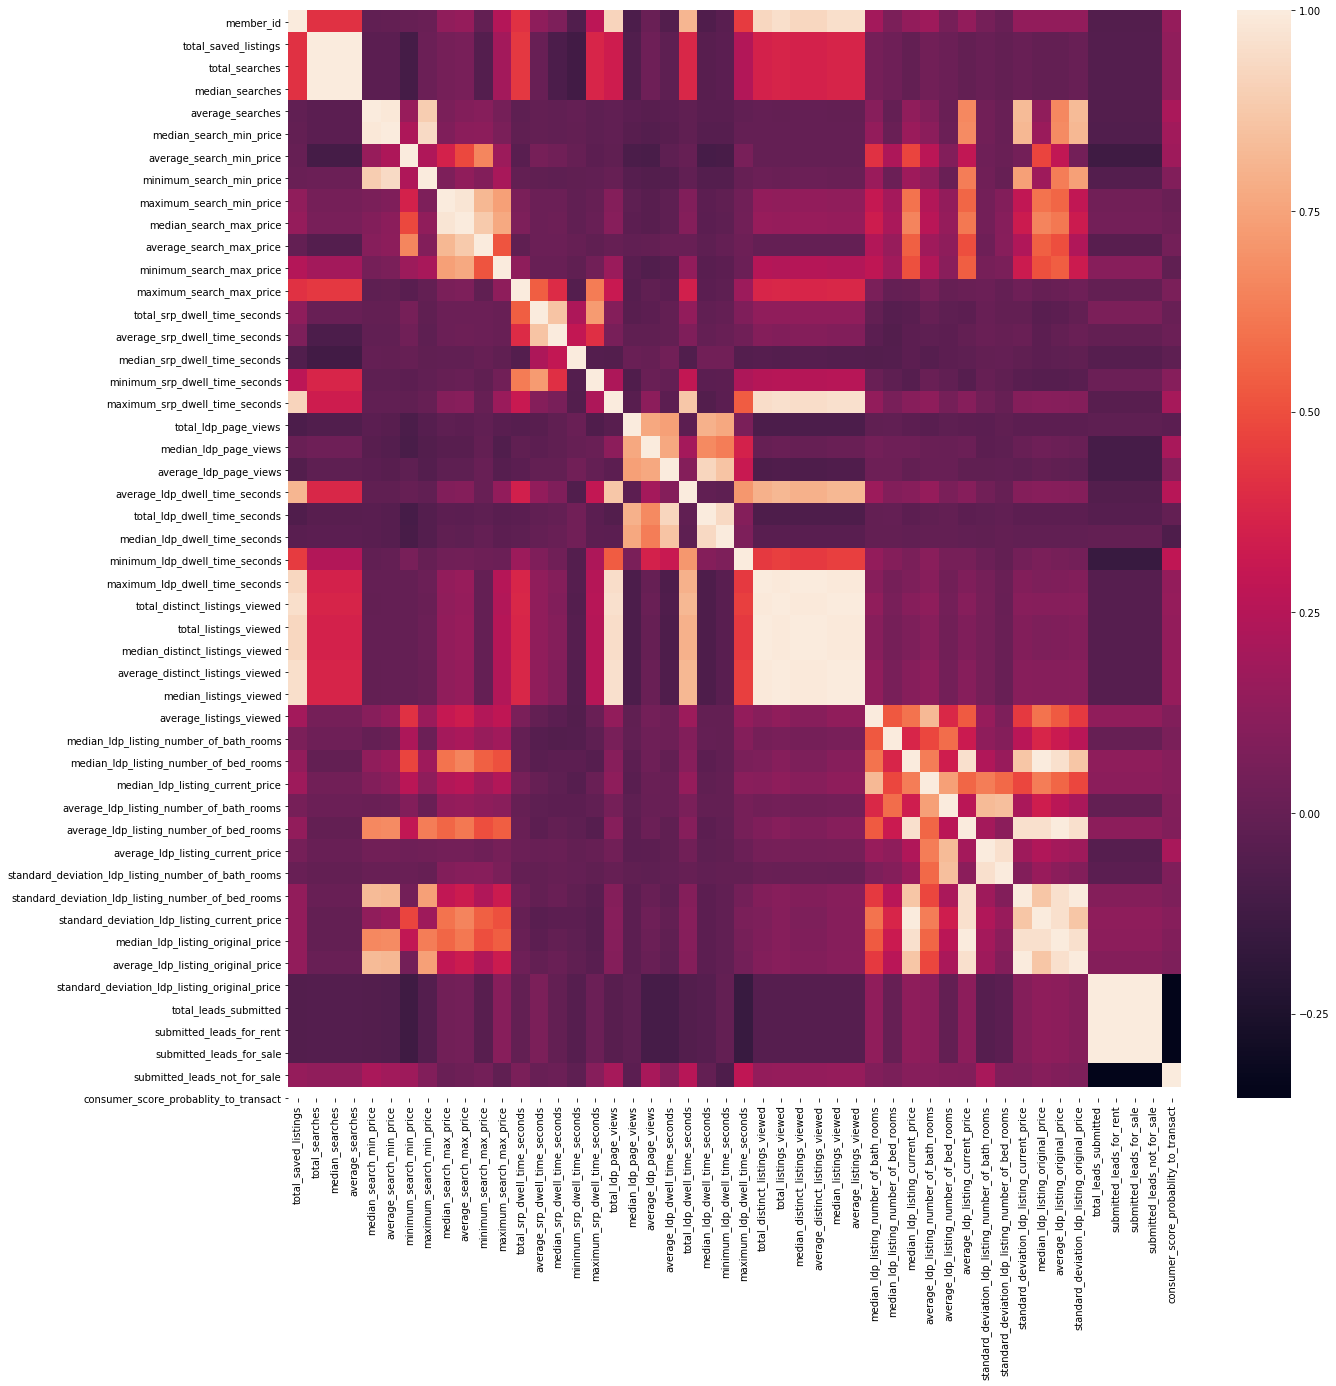

In [24]:
df_for_sale_030_corr = df_for_sale_030.corr()
pyplot.figure(figsize=(20, 20))
sns.heatmap(df_for_sale_030_corr, xticklabels=df_for_sale_030_corr.columns, yticklabels=df_for_sale_030.columns)

In [25]:
df_for_sale_030 = df_for_sale_030.drop(columns = ['total_distinct_listings_viewed','total_listings_viewed','median_distinct_listings_viewed','average_distinct_listings_viewed', 
                                          'median_listings_viewed','average_listings_viewed','submitted_leads_for_rent','submitted_leads_for_sale', 'submitted_leads_not_for_sale'])
df_for_sale_030.head(5)

,member_id,total_saved_listings,total_searches,median_searches,average_searches,median_search_min_price,average_search_min_price,minimum_search_min_price,maximum_search_min_price,median_search_max_price,...,average_ldp_listing_number_of_bed_rooms,average_ldp_listing_current_price,standard_deviation_ldp_listing_number_of_bath_rooms,standard_deviation_ldp_listing_number_of_bed_rooms,standard_deviation_ldp_listing_current_price,median_ldp_listing_original_price,average_ldp_listing_original_price,standard_deviation_ldp_listing_original_price,total_leads_submitted,consumer_score_probablity_to_transact
0,5cf5611b94c1656b69043e54,34,10,10,10.0,NaN,NaN,NaN,NaN,NaN,...,3.037313,487801.068027,1.146455,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,0.55
1,5cf5611b94c1656b69043e54,34,10,10,10.0,NaN,NaN,NaN,NaN,NaN,...,3.037313,487801.068027,1.146455,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,0.56
2,5cf5611b94c1656b69043e54,34,10,10,10.0,NaN,NaN,NaN,NaN,NaN,...,3.037313,487801.068027,1.146455,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,0.55
3,5cf5611b94c1656b69043e54,34,10,10,10.0,NaN,NaN,NaN,NaN,NaN,...,3.037313,487801.068027,1.146455,1.071902,461933.261764,399900.0,487801.068027,461933.261764,4,0.55
4,59d3764fc56563d43302879f,66,51,51,51.0,NaN,NaN,NaN,NaN,600000.0,...,2.903448,472370.202703,1.132190,0.930383,498526.107028,369900.0,472370.202703,498526.107028,1,0.63


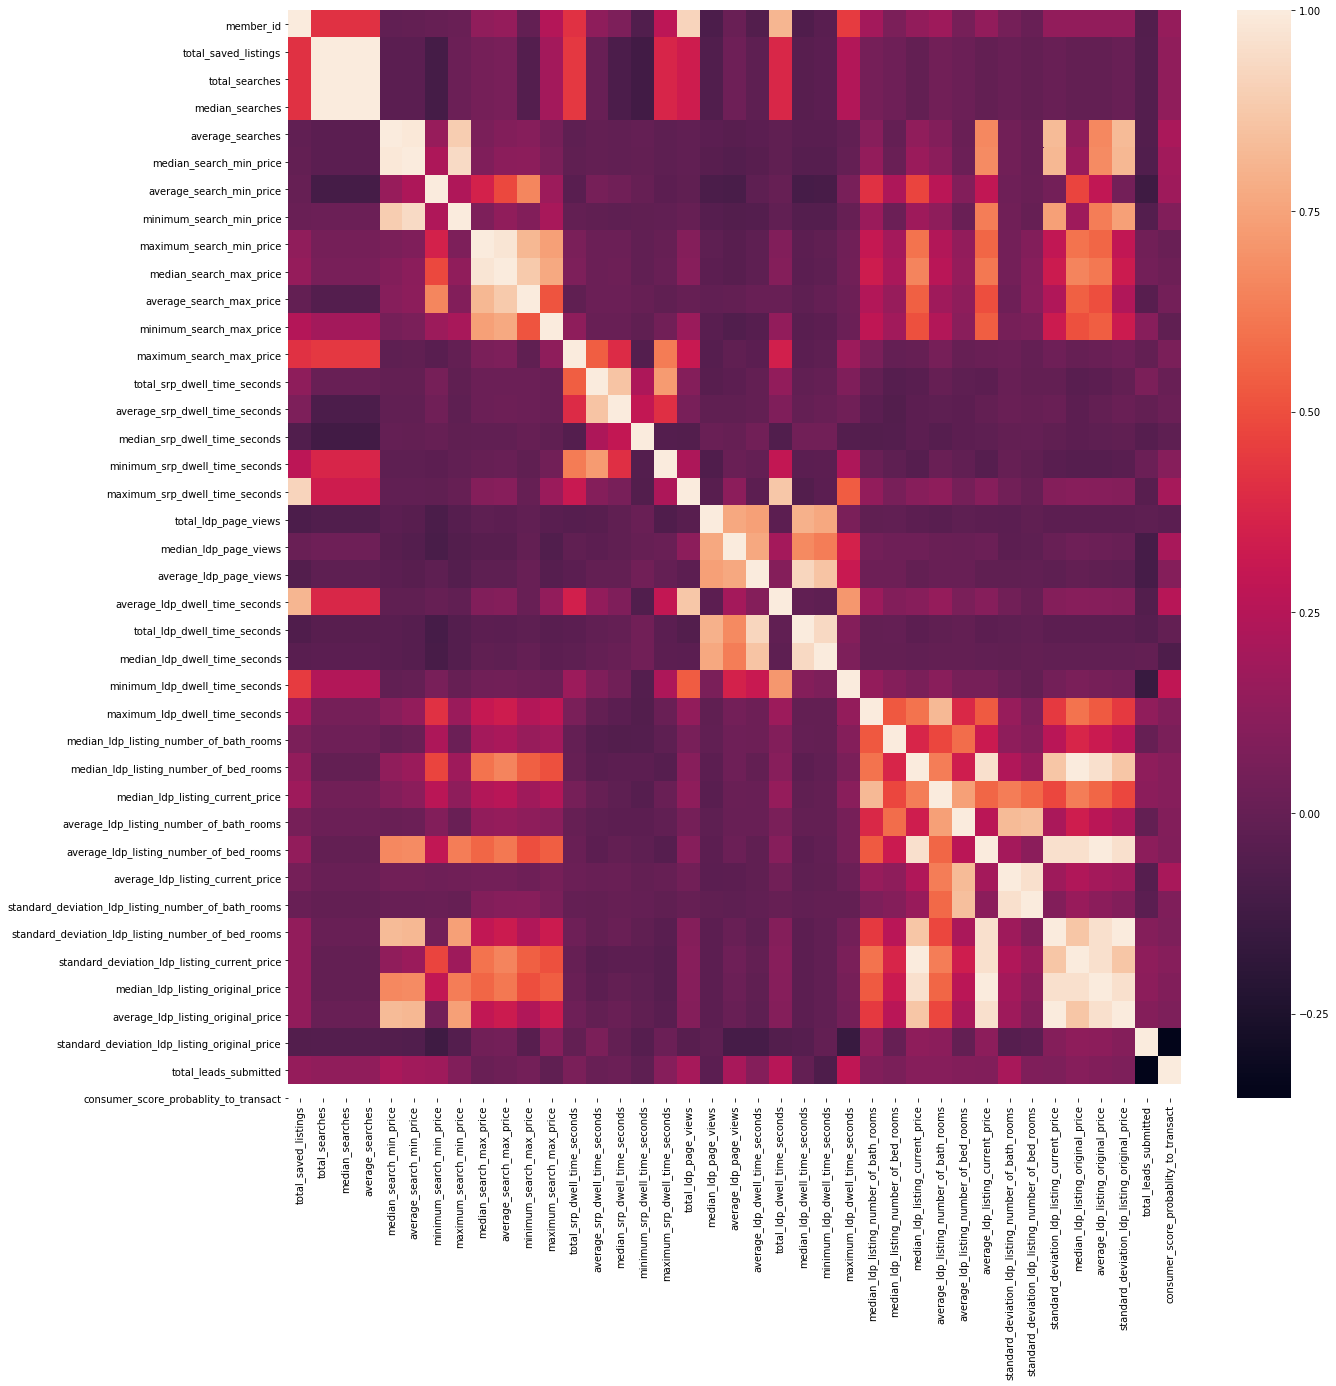

In [26]:
df_for_sale_030_corr = df_for_sale_030.corr()
pyplot.figure(figsize=(20, 20))
sns.heatmap(df_for_sale_030_corr, xticklabels=df_for_sale_030_corr.columns, yticklabels=df_for_sale_030.columns)

In [27]:
res = df_for_sale_030['total_leads_submitted'].corr(df_for_sale_030['consumer_score_probablity_to_transact'])
print(" correlation between lead_submition to consumer score : {}".format(str(res)))

 correlation between lead_submition to consumer score : -0.35473253796273435


In [28]:
df_for_sale_030.to_csv("filtered_intr_lead_trans_030.csv")